# Review analysis

In this notebook, we conduct all general analyses from the paper section 5. For the analysis of the second review, and the reasoning for the subsequent omission of the Expertise dimension in these analyses, see '2nd_review_analysis.ipynb'.

In [110]:
# Load the data
from pathlib import Path
import pandas as pd
import numpy as np

data_csv = Path("reviews.csv")

if not data_csv.exists():  # Make sure the file exists, otherwise compile it
    from result_compiler import main as data_compiler
    data_compiler()

df = pd.read_csv(data_csv)

# Sort the venues (sources) in the DataFrame as AAAI, IJCAI then ICML, NeurIPS and JAIR, JMLR
source_order = ["AAAI", "IJCAI", "ICLR", "ICML", "NeurIPS", "JAIR", "JMLR"]
df["source"] = pd.Categorical(df["source"], source_order)
# Drop the index column
df.drop("index", axis=1, inplace=True)

# Import the analysis/visualisation libraries
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import latex
pio.kaleido.scope.mathjax = None

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)  

# Define default plot layout
review_categories = ["Implementation", "Data", "Configuration", "Experimental Procedure", "Expertise"]
dimensions = review_categories[:-1]
width = 450
height = 200
layout = dict(
    boxmode="group",
    width=width * (1/0.6),
    height=height * (1/0.6),
    font=dict(
        family="serif",
        size=15,
    ),
    margin=dict(
        t=10,
        b=10,
        l=10,
        r=10,
    ),
    xaxis=dict(
        tickangle=0,
    ),
    yaxis=dict(
        title="Cost",
        range=[1, 10],
        dtick = 1,
    ),
    legend_title=None,
    legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=1),
)

/var/folders/78/9cl0kydx0g3cdzjyk28yzr7w0000gn/T/ipykernel_76084/113891862.py:25: DeprecationWarning:


Use of plotly.io.kaleido.scope.mathjax is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.mathjax instead.




## General Metrics

In this section of the notebook, we extract general metrics over all sources, such as the implementation rate and data set statistics. We also count the number of theoretical papers and *drop them from the dataset* s.t. as they are not part of any further analysis.



In [111]:
# Create a general dataset statistics table
header = source_order
years = list(df["year"].unique())

values = []
for year in years:
    values.append([])
    for source in header:
        subset = df[(df["source"] == source) & (df["year"] == year)]
        values[-1].append(f"{len(subset[subset["theoretical"] == False])} ({len(subset[subset["theoretical"] == True])})")

# Add total row
values.append([])
for source in header:
    subset = df[(df["source"] == source)]
    values[-1].append(f"{len(subset[subset["theoretical"] == False])} ({len(subset[subset["theoretical"] == True])})")
gen_stats = latex.latex_table(columns=header, rows=years + ["Total"], values=values, label="tab:data_summary", column_char="r",
                              caption="A summary of the collected data, where the first number represents the number of applicable reviews "
                                      "and the number of excluded (theoretical) papers is represented in brackets. "
                                      f"We collected {len(df[df["theoretical"] == False])} applicable reviews out of {len(df)} total papers reviewed.")
latex.compile_latex(gen_stats, "tables/general_statistics")
# Measure the amount of theoretical papers that we will have to discount
theoretical_papers = df["theoretical"].sum()
print(f"Total number of theoretical papers: {theoretical_papers}. Percentage: {(theoretical_papers / len(df) * 100).round(4)}%")

df = df[df["theoretical"] == False]
df.drop(["theoretical"], axis=1, inplace=True)
print(f"Total number of applicable papers: {len(df)}")

# Measure the amount of papers that have implementation URLS
df["implementation_link"] = df["implementation_url"].notna()
print(f"Total number of implementation URLs: {df["implementation_link"].sum()}. Percentage: {(df["implementation_link"].sum() / len(df) * 100).round(4)}%")

# Measure the amount of data sets used and how many were public vs private
avg = (df["public_datasets"].sum() / df["total_datasets"].sum() * 100).round(2)
title = f"Public data sets vs Total Data sets ({avg}%)"
plot = px.bar(df, x="public_datasets", y="total_datasets", title=title)
plot.show()

df["public_data_fraction"] = df["public_datasets"] / df["total_datasets"]
print("Number of papers / percentage that only use private data:", len(df[df["public_datasets"] == 0]), round(len(df[df["public_datasets"] == 0]) / len(df) * 100, 2))
df.drop(["public_datasets", "total_datasets"], axis=1, inplace=True)


# Calculate the papers with implementation url and cost >= 5 based on the guideline
bad_url_count = len(df[(df["implementation_link"] == True) & (df["Implementation"] >= 5)])
print(f"The bad URL count is: {bad_url_count}")


Total number of theoretical papers: 143. Percentage: 13.4779%
Total number of applicable papers: 918
Total number of implementation URLs: 583. Percentage: 63.5076%


Number of papers / percentage that only use private data: 36 3.92
The bad URL count is: 48


After reading the papers, we had a sneaking suspicion... 

In [112]:
# Random statistic for fun
def average_title_length(df: pd.DataFrame, source: str, year: int) -> None:
    return df.query(f"source == '{source}' and year == {year}")["title"].apply(len).mean().__round__(2)
print("AAAI average title lengths over 3 years:",
      average_title_length(df, "AAAI", 2022),
      average_title_length(df, "AAAI", 2023),
      average_title_length(df, "AAAI", 2024))
print("ICML average title lengths over 3 years:",
      average_title_length(df, "ICML", 2022),
      average_title_length(df, "ICML", 2023),
      average_title_length(df, "ICML", 2024))
print("IJCAI average title lengths over 3 years:",
      average_title_length(df, "IJCAI", 2022),
      average_title_length(df, "IJCAI", 2023),
      average_title_length(df, "IJCAI", 2024))
print("JAIR average title lengths over 3 years:",
      average_title_length(df, "JAIR", 2022),
      average_title_length(df, "JAIR", 2023),
      average_title_length(df, "JAIR", 2024))
print("JMLR average title lengths over 3 years:",
      average_title_length(df, "JMLR", 2022),
      average_title_length(df, "JMLR", 2023),
      average_title_length(df, "JMLR", 2024))
print("NeurIPS average title lengths over 3 years:",
      average_title_length(df, "NeurIPS", 2022),
      average_title_length(df, "NeurIPS", 2023),
      average_title_length(df, "NeurIPS", 2024))


AAAI average title lengths over 3 years: 76.39 74.6 81.04
ICML average title lengths over 3 years: 65.83 71.47 72.81
IJCAI average title lengths over 3 years: 74.42 72.19 77.21
JAIR average title lengths over 3 years: 71.49 74.86 71.94
JMLR average title lengths over 3 years: 73.15 68.21 71.39
NeurIPS average title lengths over 3 years: 63.8 73.29 74.73


Interesting! But lets not delve into the statistical significance of it ;)

In [113]:
df.rename({"implementation_link": "Public Code", "public_data_fraction": "Public Data"}, axis=1).columns

Index(['source', 'year', 'title', 'authors', 'keywords', 'pdf_path', 'awards',
       'implementation_url', 'Implementation',
       'Implementation_appendix_mentions', 'Implementation_checklist_mentions',
       'Data', 'Data_appendix_mentions', 'Data_checklist_mentions',
       'Configuration', 'Configuration_appendix_mentions',
       'Configuration_checklist_mentions', 'Experimental Procedure',
       'Experimental Procedure_appendix_mentions',
       'Experimental Procedure_checklist_mentions', 'Expertise',
       'Expertise_appendix_mentions', 'Expertise_checklist_mentions',
       'Public Code', 'Public Data'],
      dtype='object')

Now we calculate the average and standard deviations of each venue/dimension combination and create several tables to use for the paper

In [115]:
# Columns
corr_df = df.rename({"implementation_link": "Public Code", "public_data_fraction": "Public Data"}, axis=1)
other_cols = dimensions
cols_of_interest = ["Public Code", "Public Data"] + other_cols
group_col = "source"

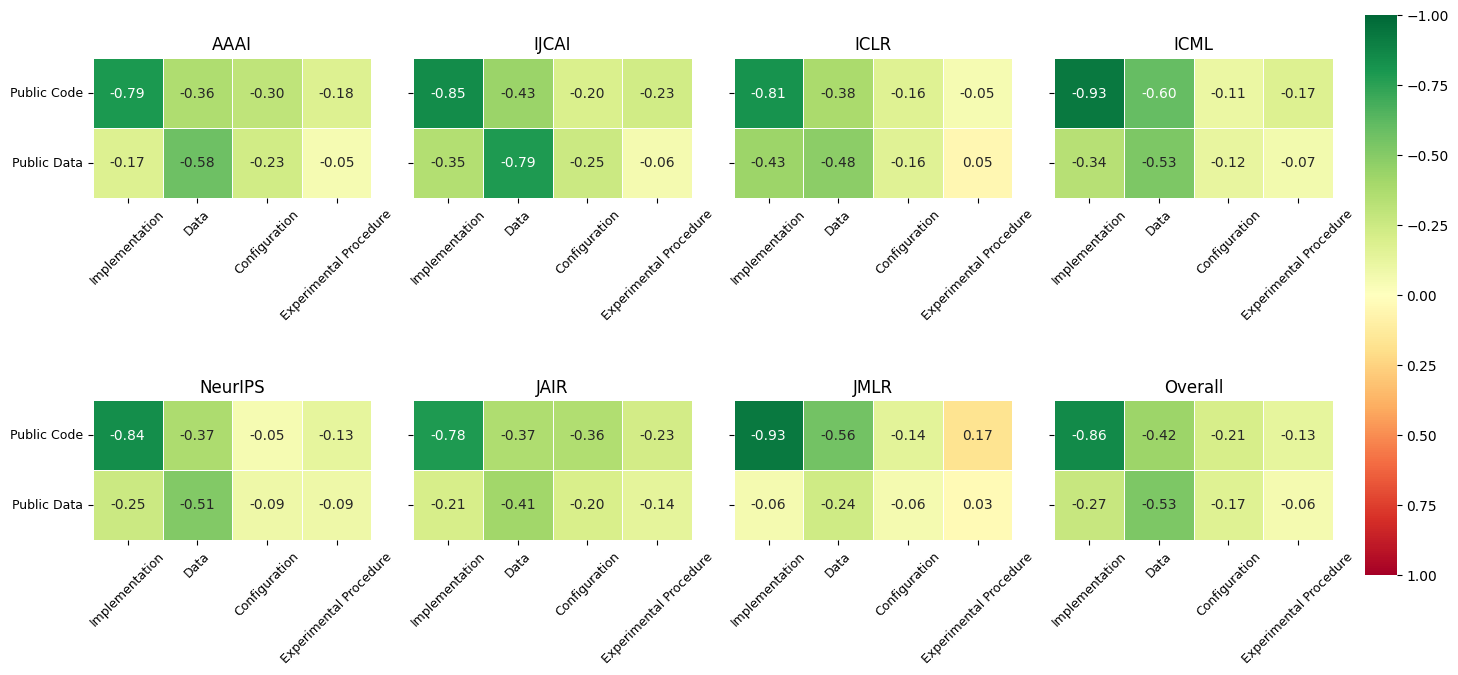

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume cols_of_interest and group_col are defined externally
# cols_of_interest = ['colA', 'colB', 'col1', 'col2', ...]
# group_col = 'source'

groups = list(corr_df[group_col].unique()) + ['Overall']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Single colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

for i, grp in enumerate(groups):
    if grp == 'Overall':
        df_grp = corr_df[cols_of_interest].copy()
    else:
        df_grp = corr_df[corr_df[group_col] == grp][cols_of_interest].copy()
    
    if df_grp.empty:
        print(f"Group '{grp}' has no data, skipping.")
        continue
    
    corr_full = df_grp.corr()
    corr_matrix_df = corr_full.loc[cols_of_interest[:2], cols_of_interest[2:]]

    sns.heatmap(
        corr_matrix_df,
        annot=True,
        fmt=".2f",
        cmap=sns.color_palette("RdYlGn_r", as_cmap=True),  # Green=-1, Red=+1
        vmin=-1,
        vmax=1,
        ax=axes[i],
        cbar=i==0,
        cbar_ax=cbar_ax if i==0 else None,
        linewidths=0.5,
        linecolor='white',
        annot_kws={"size": 10, },  # <-- bold text here
        square=True
    )
    
    axes[i].set_title(grp, fontsize=12)
    
    axes[i].tick_params(axis='x', rotation=45, labelsize=9)
    
    # Only first column gets y-axis labels
    if i % 4 != 0:
        axes[i].set_ylabel('')
        axes[i].set_yticklabels([])
    else:
        axes[i].tick_params(axis='y', rotation=0, labelsize=9)

# Remove empty subplots if fewer than 8 groups
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing between subplots to reduce vertical white space
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# Flip colorbar legend
cbar_ax.invert_yaxis()

plt.savefig(f"latex/plots/correlation_total.pdf", format="pdf", dpi=300)
plt.show()